In [1]:
# modifying LSSTCam_SV-ddf-3.ipynb to add better dithering.

In [2]:
# Import the needed packages

import os
import copy
import warnings
import logging
import numpy as np
import healpy as hp
import skyproj
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time, TimeDelta
import astropy.units as u
import astropy
astropy.utils.iers.conf.iers_degraded_accuracy = 'ignore'

from zoneinfo import ZoneInfo

timezone = "Chile/Continental"
tz = ZoneInfo(timezone)
tz_utc = ZoneInfo("UTC")

# For making airmass plots, if desired
from astroplan import FixedTarget, Observer
from astroplan.plots import plot_airmass

from rubin_scheduler.scheduler.utils import generate_all_sky, Footprint

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site, angular_separation

from rubin_scheduler.scheduler.model_observatory import ModelObservatory, KinemModel
from rubin_scheduler.scheduler.schedulers import SimpleBandSched, CoreScheduler
import rubin_scheduler.scheduler.example as ex
from rubin_scheduler.scheduler.surveys import FieldSurvey
import rubin_scheduler.scheduler.basis_functions as basis_functions
import rubin_scheduler.scheduler.detailers as detailers

from rubin_scheduler.scheduler.utils import SchemaConverter, run_info_table
import rubin_sim.maf.plots as plots
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.metric_bundles as mb
from rubin_sim.maf.db import ResultsDb

from rubin_scheduler.scheduler import features
from rubin_scheduler.scheduler.basis_functions import BaseBasisFunction
from rubin_scheduler.utils import _angular_separation
from rubin_scheduler.scheduler.detailers import BaseDetailer

# If running on the USDF, find rubin_scheduler data here:
if "usdf" in os.getenv("EXTERNAL_INSTANCE_URL", ""):
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

In [3]:
# When might we start and end the survey?
# What would the actual time on-sky look like? 
# (start on dayobs rollover, so T12:00:00)
survey_start = Time('2025-06-11T12:00:00', format='isot', scale='utc')
survey_end = Time('2025-08-30T12:00:00', format='isot', scale='utc')
survey_length = int(np.ceil((survey_end - survey_start).jd))

nside = 32

print(survey_start.iso, survey_end.isot, survey_length)

site = Site("LSST")
almanac = Almanac(mjd_start=survey_start.mjd)
match = np.where(
    (almanac.sunsets["night"] >= 0) & (almanac.sunsets["night"] <= survey_length)
)
sunsets = almanac.sunsets[match]["sun_n18_setting"]
sunrises = almanac.sunsets[match]["sun_n18_rising"]

print(Time(sunsets[0], format='mjd', scale='utc').iso, 
      Time(sunrises[0], format='mjd', scale='utc').iso, 
      Time(sunsets[-1], format='mjd', scale='utc').iso, 
      Time(sunrises[-1], format='mjd', scale='utc').iso)

sun_ra_start = almanac.get_sun_moon_positions(survey_start.mjd,)["sun_RA"][0]
print(sun_ra_start)

2025-06-11 12:00:00.000 2025-08-30T12:00:00.000 80
2025-06-10 23:14:51.415 2025-06-11 10:10:30.431 2025-08-29 23:46:22.102 2025-08-30 09:40:37.585
1.3897159617309942


Text(0.5, 1.0, 'SV surveys from 2025-06-11 to 2025-08-30')

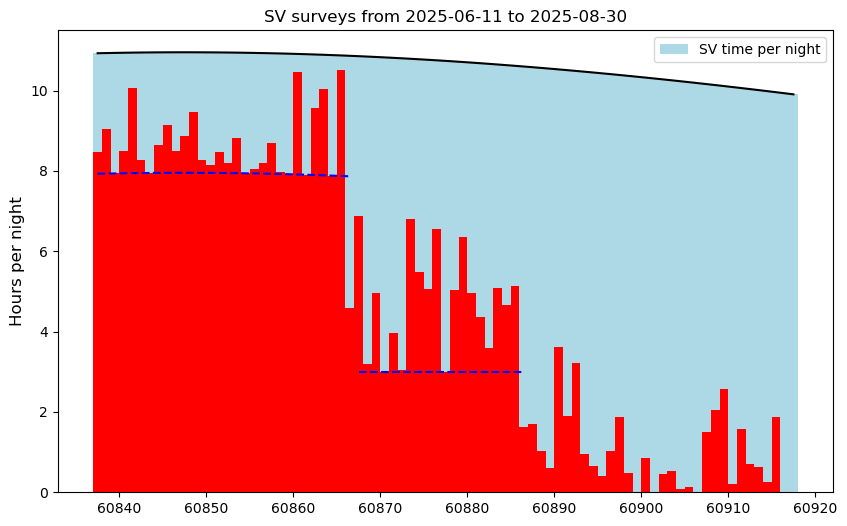

In [4]:
# Set up an approximation for downtime, including masking time used for other engineering

# Let's assume for the first 30 days only the last 3 hours of the night are available
step1 = 30
down_starts = sunsets[0:step1]
down_ends = sunrises[0:step1] - 3.0 / 24
step2 = 50
down_starts = np.concatenate([down_starts, sunsets[step1:step2]])
down_ends = np.concatenate([down_ends, sunsets[step1:step2] + 3.0 / 24])
# And then from July through end of August, gets all of the night - don't have to specify
# but for random downtime below, will do so anyway
down_starts = np.concatenate([down_starts, sunsets[step2:]])
down_ends = np.concatenate([down_ends, sunsets[step2:]])

# But let's add random periods of downtime within each night
rng = np.random.default_rng(seed=55)
# Assume some chance of having some amount of downtime
# (but this is simplistic and assumes downtime once per night
threshold = .7
prob_down = rng.random(len(sunsets))
time_down = rng.gumbel(loc=0.5, scale=1, size=len(sunsets)) # in hours
hours_in_night = (sunrises - sunsets) * 24
avail_in_night = (sunrises - sunsets) * 24 - (down_ends - down_starts) * 24
time_down = np.where(time_down >= avail_in_night, avail_in_night - 0.1, time_down) 
time_down = np.where(time_down <= 0, 0, time_down)

latest_start = avail_in_night - time_down
d_starts = rng.uniform(low=down_ends, high=down_ends + latest_start / 24.0)
d_ends = d_starts + time_down / 24.0

# combine
down_starts = np.concatenate([down_starts, d_starts])
down_ends = np.concatenate([down_ends, d_ends])

# Can make an array of downtimes - 
# down_starts/ down_ends should be mjd times for internal-ModelObservatory use
downtimes = np.array(
                list(zip(down_starts, down_ends)),
                dtype=list(zip(["start", "end"], [float, float])),
            )
downtimes.sort(order="start")

dayobsmjd = np.arange(survey_start.mjd, survey_start.mjd + survey_length+0.5, 1)
downtime_per_night = np.zeros(len(sunrises))
for start, end in zip(downtimes['start'], downtimes['end']):
    idx = np.where((start > dayobsmjd) & (end < dayobsmjd+1))
    downtime_per_night[idx] += (end - start) * 24

plt.figure(figsize=(10,6))
plt.plot(dayobsmjd, hours_in_night, 'k')
w = 1
plt.bar(dayobsmjd, downtime_per_night, width=w, color='r')
plt.bar(dayobsmjd, hours_in_night - downtime_per_night, bottom=downtime_per_night, width=w,
        color='lightblue', label="SV time per night")
plt.plot(dayobsmjd[0:step1], hours_in_night[0:step1] - 3, 'b--')
plt.plot(dayobsmjd[step1:step2], np.ones(step2-step1) * 3, 'b--')
plt.legend()
plt.ylabel("Hours per night", fontsize='large')
plt.title(f"SV surveys from {survey_start.iso[0:10]} to {survey_end.iso[0:10]}")

lst midnight @ start 259.70350688612876 lst midnight @ mid 300.8018374851897 lst midnight @ end 338.75996600951345
lst sunset @ mid 220.05065466268965 lst sunrise @ mid 21.553020326628957
south area 1175.0111032956336 south approx n fields 159.11608690461708
north area 651.2918686838655 south approx n fields 88.19577388427346
total area 1826.302971979499 total approx n fields 247.31186078889056
approx blob fields 99.0
closest approach to ecliptic in south area (deg)? -53.97543841632944
max/min elevation in south? 9.983784728061089 28.675375352803158
max/min elevation in north? 25.46420815280084 35.02459184719916
DDF radius 5.641895835477563 DD area, not including dither edges 100.71523742534 very approximate n fields 151.07285613801002
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


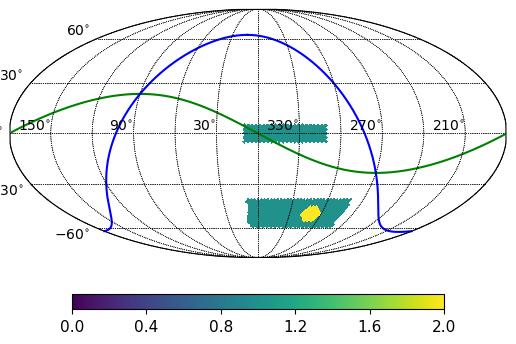

In [5]:
# Need to define the footprint (let's start with the wide area footprint)

sky = generate_all_sky(nside=nside)

# middle of the night in the middle of the survey
loc = site.to_earth_location()
idx = int(survey_length / 2)
mid_survey = Time(sunsets[idx] + (sunrises[idx] - sunsets[idx])/2, format='mjd', scale='utc', location=loc)
mid_lst = mid_survey.sidereal_time('mean')
idx = 0
start_lst = Time(sunsets[idx] + (sunrises[idx] - sunsets[idx])/2, format='mjd', scale='utc', location=loc).sidereal_time('mean')
idx = -1
end_lst = Time(sunsets[idx] + (sunrises[idx] - sunsets[idx])/2, format='mjd', scale='utc', location=loc).sidereal_time('mean')

print('lst midnight @ start', start_lst.deg, 'lst midnight @ mid', mid_lst.deg, 'lst midnight @ end', end_lst.deg)
idx = int(survey_length / 2)
sunset_mid_lst = Time(sunsets[idx], format='mjd', scale='utc', location=loc).sidereal_time('mean')
sunrise_mid_lst = Time(sunrises[idx], format='mjd', scale='utc', location=loc).sidereal_time('mean')
print('lst sunset @ mid', sunset_mid_lst.deg, 'lst sunrise @ mid', sunrise_mid_lst.deg)

# Keith's suggested areas - two regions .. 
south = np.where((((sky['ra'] > 280) & (sky['ra'] <= 360)) | ((sky['ra'] >= 0) & (sky['ra'] < 10))) 
                 & (sky['dec'] < -40) & (sky['dec'] > -60))
north = np.where((((sky['ra'] > 310) & (sky['ra'] <= 360)) | ((sky['ra'] >= 0) & (sky['ra'] < 10))) 
                 & (sky['dec'] < 5) & (sky['dec'] > -5))

sky['map'] = np.zeros(hp.nside2npix(nside)) + np.nan
sky['map'][south] = 1
sky['map'][north] = 1

# Check individually, relevant for blob coverage.. 
area_south = len(np.where(sky['map'][south] == 1)[0]) * hp.nside2pixarea(nside, degrees=True)
approx_nfields_south = area_south / 9.6 * 1.3
print('south area', area_south, 'south approx n fields', approx_nfields_south)
area_north = len(np.where(sky['map'][north] == 1)[0]) * hp.nside2pixarea(nside, degrees=True)
approx_nfields_north = area_north / 9.6 * 1.3
print('north area', area_north, 'south approx n fields', approx_nfields_north)
# And together
print('total area', area_south + area_north, 'total approx n fields', approx_nfields_south + approx_nfields_north)

# How many fields are typically in a 'blob' with pair time of 33 minutes?
print('approx blob fields',  33 * 2 * 60 / (32+8))
# so .. looks like we'd cover the north and then south in a single blob of pairs each?
      

print('closest approach to ecliptic in south area (deg)?', sky['eclip_lat'][south].min())
print('max/min elevation in south?', abs(sky['dec'][south].max() - site.latitude), abs(sky['dec'][south].min() - site.latitude))
print('max/min elevation in north?', abs(site.latitude - sky['dec'][north].min()), abs(site.latitude - sky['dec'][north].max()))

dd_ra = 310
dd_dec = -50
radius = np.sqrt(100 / np.pi)
dist = angular_separation(dd_ra, dd_dec, sky['ra'], sky['dec'])
close = np.where(dist <= radius)[0]
dd = np.zeros(hp.nside2npix(nside)) + np.nan
dd[close] = 1

area_dd = len(np.where(dd == 1)[0]) * hp.nside2pixarea(nside, degrees=True)
approx_nfields_dd = area_dd * 1.5
print("DDF radius", radius, "DD area, not including dither edges", area_dd, "very approximate n fields", approx_nfields_dd)

temp = np.where(np.isnan(sky['map']), 0, sky['map']) +  np.where(np.isnan(dd), 0, 2*dd)
temp[np.where(temp == 0)] = np.nan
temp = np.ma.MaskedArray(temp)
s = slicers.HealpixSlicer(nside=nside)
p = plots.HpxmapPlotter()
fig = p(temp, s, {'color_max': 2, 'color_min': 0, 'n_ticks': 5})

In [6]:
# Turn this into a Footprint to use with the scheduler - 
# low-dust-ratios
lowdust_band_ratios = {"u": 0.35, "g": 0.4, "r": 1.0, "i": 1.0, "z": 0.9, "y": 0.9}
dd_footprints_hp = np.zeros(hp.nside2npix(nside), 
                         dtype=list(zip(["u", "g", "r", "i", "z", "y"], [float] * 7)),)
for b in 'ugrizy':
    dd_footprints_hp[b] = dd * lowdust_band_ratios[b] * 3
    dd_footprints_hp[b][np.isnan(dd_footprints_hp[b])] = 0

# estimates of number of visits per night / sequence for DDF (for field survey)
dd_goals = [round(lowdust_band_ratios[k] * 184) for k in lowdust_band_ratios]
print(dd_goals, np.array(dd_goals)/30, np.array(dd_goals).sum()/30)
# This would likely be the necessary visits per night that are required? But sim fails.
seq = {'u': 16, 'g': 4, 'r': 12, 'i': 12, 'z': 12, 'y': 31}
# Try shorter seq
seq = {'u': 9, 'g': 2, 'r': 6, 'i': 6, 'z': 6, 'y': 15}
tt = [round(seq[k] * 1.0) for k in seq]
print((np.array(tt) * (32 + 5)).sum()/60)
       
# flat for SV 
band_ratios = {"u": 0, "g": 1.0, "r": 1.0, "i": 1.0, "z": 1.0, "y": 0}

# But maybe we want to use just the healpix in a dict .. 
footprints_hp = np.zeros(hp.nside2npix(nside), 
                         dtype=list(zip(["u", "g", "r", "i", "z", "y"], [float] * 7)),)
for b in 'ugrizy':
    footprints_hp[b] = sky['map'] * band_ratios[b]
    footprints_hp[b][np.isnan(footprints_hp[b])] = 0

# combine footprint
combined_hp = np.zeros(hp.nside2npix(nside), 
                         dtype=list(zip(["u", "g", "r", "i", "z", "y"], [float] * 7)),)
for b in 'ugrizy':
    wide_dd_masked = np.where(dd_footprints_hp[b] > 0, 0, footprints_hp[b])
    combined_hp[b] = wide_dd_masked + dd_footprints_hp[b]


# If we were going to use a Footprint object directly (or to check basis function)
# footprint = Footprint(mjd_start = survey_start.mjd, 
#                       sun_ra_start = sun_ra_start)                     
# for b in 'ugrizy':
#     footprint.set_footprint(bandname=b, values=sky['map'] * band_ratios[b])

[64, 74, 184, 184, 166, 166] [2.13333333 2.46666667 6.13333333 6.13333333 5.53333333 5.53333333] 27.933333333333334
27.133333333333333


In [7]:
# Tag things as "in the deep"
class TagRadialDetailer(BaseDetailer):
    def __init__(self, radius=5.6, ra=0, dec=-30., note_append=", deep area"):
        self.survey_features = {}
        self.radius = np.radians(radius)
        self.ra = np.radians(ra)
        self.dec = np.radians(dec)
        self.note_append = note_append
        
    def __call__(self,obsarray, conditions):
        distances = _angular_separation(obsarray["RA"], obsarray["dec"], self.ra, self.dec)
        in_region = np.where(distances <= self.radius)[0]
        obsarray["scheduler_note"][in_region] = np.char.add(obsarray["scheduler_note"][in_region], self.note_append)
        return obsarray


# let's make a way to make sure we don't just hammer a single filter all night
class BandBalanceBasisFunction(BaseBasisFunction):
    """Prevent a filter from executing more than a set fraction of the time in a night
    """
    def __init__(self, bandname="r", fraction_to_limit=0.4, n_limit=200):
        super().__init__(bandname=bandname)
        self.n_limit = n_limit
        self.fraction_to_limit = fraction_to_limit
        self.survey_features["n_all"] = features.NObsCount(bandname=None, per_night=True)
        self.survey_features["n_in_band"] = features.NObsCount(bandname=bandname, per_night=True)
        
    def check_feasibility(self, conditions):
        if self.survey_features["n_all"].feature <= self.n_limit:
            return True
        ratio = self.survey_features["n_in_band"].feature / self.survey_features["n_all"].feature
        if ratio <= self.fraction_to_limit:
            return True
        else:
            return False

In [8]:
# Pull up a pretty standard set of masks and a simple pair survey

standard_masks = ex.standard_masks(nside=nside, moon_distance=30, wind_speed_maximum=40)

camera_rot_limits = [-80, 80]

# And set up some simple pairs surveys .. probably will need modification
# (also this is slow because the simple_pairs_survey is redoing some of the work already done above ..hmm)
standard_pairs = [['u', 'g'], ['u', 'r'], ['g', 'r'], ['r', 'i'], ['i', 'z'], ['z', 'y'], ['y', 'y']]
sv_pairs = [['u', 'u'], ['g', 'r'], ['r', 'i'], ['i', 'z'], ['g', 'z'], ['y', 'y']]
pair_surveys = {}
for b1, b2 in sv_pairs:
    pair_surveys[f"{b1}{b2}"] = ex.simple_pairs_survey(nside=nside, bandname=b1, bandname2=b2, 
                                                 mask_basis_functions=standard_masks,
                                                 reward_basis_functions=None,
                                                 reward_basis_functions_weights=None,
                                                 footprints_hp=combined_hp,
                                                 survey_start=survey_start.mjd,
                                                 camera_rot_limits=camera_rot_limits,
                                                 pair_time=33, 
                                                 exptime=30, 
                                                 nexp=1, 
                                                 science_program='BLOCK-P',
                                                      dither="call",
                                                      camera_dither="call")
    # Very bad way to just reach in and change things after the fact
    bonus_bfs = [BandBalanceBasisFunction(bandname=b1), BandBalanceBasisFunction(bandname=b2)]
    pair_surveys[f"{b1}{b2}"].basis_functions = pair_surveys[f"{b1}{b2}"].basis_functions + bonus_bfs
    pair_surveys[f"{b1}{b2}"].basis_weights = pair_surveys[f"{b1}{b2}"].basis_weights + [0]*len(bonus_bfs)
    tag_detailer = TagRadialDetailer(radius=radius, ra=dd_ra, dec=dd_dec)
    pair_surveys[f"{b1}{b2}"].detailers.append(tag_detailer)
    

# We'll probably need greedy surveys to fill short periods of time
greedy_surveys = {}
for b in 'ugrizy':
    greedy_surveys[b] = ex.simple_greedy_survey(nside=nside, 
                                                bandname=b,
                                                mask_basis_functions=standard_masks,
                                                reward_basis_functions=None,
                                                reward_basis_functions_weights=None,
                                                survey_start=survey_start.mjd, 
                                                footprints_hp=combined_hp,
                                                camera_rot_limits=camera_rot_limits,
                                                exptime=30,
                                                nexp=1,
                                                science_program='BLOCK-G',
                                               dither="call",
                                               camera_dither="night")
    tag_detailer = TagRadialDetailer(radius=radius, ra=dd_ra, dec=dd_dec)
    greedy_surveys[b].detailers.append(tag_detailer)


In [9]:
# DDF as field survey
# survey_lists = [[copy.deepcopy(dd_survey)], [copy.deepcopy(pair_surveys[k]) for k in pair_surveys], [copy.deepcopy(greedy_surveys[k]) for k in greedy_surveys]]

# DDF as greedy survey
# survey_lists = [[copy.deepcopy(dd_surveys[k]) for k in dd_surveys] + [copy.deepcopy(pair_surveys[k]) for k in pair_surveys], [copy.deepcopy(greedy_surveys[k]) for k in greedy_surveys]]

# DDF embedded in other footprint
survey_lists = [[copy.deepcopy(pair_surveys[k]) for k in pair_surveys], [copy.deepcopy(greedy_surveys[k]) for k in greedy_surveys]]


logger = logging.getLogger()

scheduler = CoreScheduler(survey_lists, nside, log=logger, camera='LSST', telescope='rubin', band_to_filter={'u': 'u', 'g': 'g', 'r': 'r', 'i': 'i', 'z': 'z', 'y': 'y'})
scheduler.survey_lists

[[<BlobSurvey survey_name='simple pair 33, uu' at 0x17a463f80>,
  <BlobSurvey survey_name='simple pair 33, gr' at 0x16851ff20>,
  <BlobSurvey survey_name='simple pair 33, ri' at 0x17a377c50>,
  <BlobSurvey survey_name='simple pair 33, iz' at 0x17a375760>,
  <BlobSurvey survey_name='simple pair 33, gz' at 0x169c1a4b0>,
  <BlobSurvey survey_name='simple pair 33, yy' at 0x169bcd1c0>],
 [<GreedySurvey survey_name='simple greedy u' at 0x169bcca10>,
  <GreedySurvey survey_name='simple greedy g' at 0x169bab1a0>,
  <GreedySurvey survey_name='simple greedy r' at 0x17a376090>,
  <GreedySurvey survey_name='simple greedy i' at 0x17a463e90>,
  <GreedySurvey survey_name='simple greedy z' at 0x1787e8500>,
  <GreedySurvey survey_name='simple greedy y' at 0x1787eb890>]]

In [10]:
# What does the observatory look like?  (remember to set this back up if you change the downtimes)
setup_observatory = False
try:
    model_obs
except:
    setup_observatory = True 
    
if setup_observatory:
    model_obs = ModelObservatory(nside=nside, 
                                   mjd=survey_start.mjd, 
                                   mjd_start=survey_start.mjd, 
                                   cloud_data="ideal", # noclouds
                                   seeing_data=None, # standard seeing, but could modify
                                   wind_data=None,
                                   downtimes = downtimes)
    # Slow the telescope down with smaller jerk/acceleration, and smaller maxvel
    # But is faster with settle of 0 (Tiago is working on this)
    model_obs.setup_telescope(
        altitude_maxspeed=2.0,
        altitude_accel=2.0,
        altitude_jerk=8.0,
        azimuth_maxspeed=2.0,
        azimuth_accel=2.0,
        azimuth_jerk=8.0,
        settle_time=0.0,
    )

observatory = copy.deepcopy(model_obs)

# Filter scheduler - simply changes between ugriz and grizy depending on lunar phase
fs = SimpleBandSched(illum_limit=40)

In [11]:
#%%capture sched_log
# Catch the RuntimeWarning if calc_reward returns all nans or if we're in downtime
rewards = True
scheduler.keep_rewards=rewards

#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
vals = sim_runner(
    observatory,
    scheduler,
    band_scheduler=fs,
    sim_start_mjd=survey_start.mjd,
    sim_duration=survey_length,
    record_rewards=rewards,
    verbose=True,
)
observatory = vals[0]
scheduler = vals[1]
observations = vals[2]
if len(vals) == 5:
    rewards = vals[3]
    obs_rewards = vals[4]

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:345: UserWarning: Sun high, using bright sky approx
  warnings.warn("Sun high, using bright sky approx")
Failed to fill queue at time 60837.5
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:345: UserWarning: Sun high, using bright sky approx
  warnings.warn("Sun high, using bright sky approx")
Failed to fill queue at time 60837.510416666664
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrigh

progress = 1.12%

Failed to fill queue at time [60838.39954995]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60838.40996662]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60838.42038329]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60838.43079995]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 2.36%

Failed to fill queue at time [60839.38687365]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60839.39729032]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60839.40770698]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60839.41812365]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 3.50%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 3.60%

Failed to fill queue at time [60840.3910999]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60840.40151657]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60840.41193323]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60840.4223499]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futur

progress = 4.88%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 6.13%

Failed to fill queue at time [60842.40416156]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60842.41457822]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60842.42499489]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60842.43541156]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 7.30%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 7.36%

Failed to fill queue at time [60843.40653966]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60843.41695633]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60843.427373]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn

progress = 8.60%

Failed to fill queue at time [60844.38956526]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60844.39998193]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60844.41039859]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60844.42081526]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 9.86%

Failed to fill queue at time [60845.38569143]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60845.3961081]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60845.40652477]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60845.41694143]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futu

progress = 11.05%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 11.16%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/schedule

progress = 12.36%

Failed to fill queue at time [60847.39161799]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60847.40203465]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used

progress = 13.64%

Failed to fill queue at time [60848.41415621]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60848.42457288]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60848.43498955]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60848.44540621]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 14.90%

Failed to fill queue at time [60849.41773688]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-s

progress = 16.05%

Failed to fill queue at time [60850.38099985]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60850.39141652]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60850.40183318]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60850.41224985]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 17.30%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 17.36%

Failed to fill queue at time [60851.38745777]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60851.39787444]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60851.4082911]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.war

progress = 18.55%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 18.61%

Failed to fill queue at time [60852.42495611]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60852.43537278]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60852.44578944]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  w

progress = 19.31%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 19.75%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 19.86%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 20.56%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale fact

progress = 21.13%

Failed to fill queue at time [60854.40352933]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60854.413946]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60854.42436267]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn

progress = 21.81%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale fact

progress = 22.30%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/schedule

progress = 22.36%

Failed to fill queue at time [60855.41719922]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60855.42761589]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used

progress = 23.06%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 23.61%

Failed to fill queue at time [60856.38659357]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60856.39701024]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60856.40742691]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60856.41784357]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 24.31%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 24.86%

Failed to fill queue at time [60857.42237958]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60857.43279624]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60857.44321291]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  w

progress = 26.00%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 26.05%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 27.25%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 27.30%

Failed to fill queue at time [60859.38415869]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60859.39457536]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60859.40499202]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60859.41540869]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 28.06%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 28.61%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60860.40808405]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60860.41850072]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60860.42891739]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 29.32%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 29.90%

Failed to fill queue at time [60861.41974339]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60861.43016006]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60861.44057673]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  w

progress = 31.11%

Failed to fill queue at time [60862.39204921]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60862.40246588]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60862.41288255]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60862.42329921]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 31.82%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 32.25%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 32.40%

Failed to fill queue at time [60863.42065993]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60863.43107659]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60863.44149326]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  w

progress = 33.07%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 33.65%

Failed to fill queue at time [60864.41777466]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60864.42819133]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60864.438608]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  war

progress = 34.32%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 34.75%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 34.86%

Failed to fill queue at time [60865.42089187]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60865.43130854]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60865.4417252]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  wa

progress = 35.57%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale fact

progress = 36.14%

Failed to fill queue at time [60866.41521164]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60866.42562831]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60866.43604498]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60866.44646164]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 36.82%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 37.00%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 37.16%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 37.29%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 37.34%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 37.40%

Failed to fill queue at time [60867.42029064]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60867.43070731]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60867.44112397]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  w

progress = 38.07%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 38.65%

Failed to fill queue at time [60868.42096649]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60868.43138316]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60868.44179983]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  w

progress = 39.32%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 39.56%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 39.82%

Failed to fill queue at time [60869.38218085]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-s

progress = 41.09%

Failed to fill queue at time [60870.40622827]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60870.41664494]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60870.4270616]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60870.43747827]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futu

progress = 42.26%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 42.32%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 42.37%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 43.36%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/schedule

progress = 43.41%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 43.62%

Failed to fill queue at time [60872.39839525]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60872.40881192]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60872.41922859]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60872.42964525]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 44.50%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 44.61%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 44.71%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 44.82%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 44.87%

Failed to fill queue at time [60873.39548825]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60873.40590491]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60873.41632158]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60873.42673825]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 46.08%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 46.14%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60874.41122623]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60874.42164289]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60874.43205956]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 46.82%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 47.11%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 47.21%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 47.37%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60875.39509394]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler

progress = 48.07%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale fact

progress = 48.53%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 48.59%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 48.64%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60876.42070543]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60876.43112209]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60876.44153876]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 49.32%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale fact

progress = 49.77%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 49.87%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60877.40746613]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60877.4178828]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/g

progress = 50.57%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 51.12%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60878.41665354]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60878.42707021]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60878.43748687]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 51.82%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale fact

progress = 52.16%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 52.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 52.37%

Failed to fill queue at time [60879.40616]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60879.41657667]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60879.42699334]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60879.43741]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future an

progress = 53.07%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 53.36%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 53.41%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 53.61%

Failed to fill queue at time [60880.38763591]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60880.39805258]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60880.40846924]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60880.41888591]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 54.77%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 54.90%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60881.42266257]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60881.43307924]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60881.4434959]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying 

progress = 55.81%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 55.93%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 56.04%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 56.09%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 56.14%

Failed to fill queue at time [60882.41941238]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60882.42982905]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60882.44024571]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  w

progress = 57.22%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 57.32%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 57.38%

Failed to fill queue at time [60883.40833989]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-s

progress = 58.44%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 58.55%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 58.60%

Failed to fill queue at time [60884.38554153]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60884.3959582]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60884.40637486]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60884.41679153]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futu

progress = 59.33%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale fact

progress = 59.51%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale fact

progress = 59.65%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 59.81%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 59.86%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60885.40663866]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler

progress = 60.58%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 60.76%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 61.09%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60886.37645395]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60886.38687061]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60886.39728728]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 61.83%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 62.08%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 62.34%

Failed to fill queue at time [60887.37666507]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60887.38708174]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60887.3974984]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60887.40791507]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futu

progress = 63.08%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 63.23%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 63.34%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 63.46%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 63.51%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 63.56%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 63.61%

Failed to fill queue at time [60888.39424875]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60888.40466542]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60888.41508209]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60888.42549875]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 64.33%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 64.43%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 64.63%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 64.68%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 64.84%

Failed to fill queue at time [60889.38112477]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60889.39154144]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60889.4019581]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60889.41237477]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futu

progress = 65.58%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 65.73%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 65.91%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 65.96%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 66.01%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 66.06%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 66.12%

Failed to fill queue at time [60890.39786359]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60890.40828025]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60890.41869692]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60890.42911359]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 66.83%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 66.98%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 67.25%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 67.30%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 67.35%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/schedule

progress = 68.24%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 68.29%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 68.34%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 68.39%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 68.55%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 68.60%

Failed to fill queue at time [60892.38451802]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60892.39493469]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60892.40535136]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60892.41576802]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 69.33%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 69.49%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 69.59%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 69.69%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 69.89%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/schedule

progress = 70.58%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 70.63%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 70.68%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 70.77%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 70.82%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 70.87%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 70.97%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 71.03%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 71.08%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 71.83%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale fact

progress = 72.04%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 72.14%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 72.25%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 72.30%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60895.37898715]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60895.38940382]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60895.39982049]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 73.08%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 73.24%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 73.55%

Failed to fill queue at time [60896.37269817]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60896.38311484]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60896.3935315]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60896.40394817]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futu

progress = 74.33%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 74.79%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 74.84%

Failed to fill queue at time [60897.37860256]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60897.38901923]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60897.3994359]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60897.40985256]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futu

progress = 75.58%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 75.79%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 76.12%

Failed to fill queue at time [60898.40082668]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60898.41124335]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60898.42166001]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60898.43207668]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 76.83%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 76.99%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 77.15%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 77.36%

Failed to fill queue at time [60899.39222441]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60899.40264108]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60899.41305775]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60899.42347441]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 78.13%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 78.19%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/schedule

progress = 78.40%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 78.61%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 79.38%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 79.44%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 79.49%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 79.54%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 79.59%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 79.65%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 79.70%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 79.75%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 79.80%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 79.86%

Failed to fill queue at time [60901.38431805]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60901.39473471]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used

progress = 80.74%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 80.90%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 81.00%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 81.11%

Failed to fill queue at time [60902.38856804]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60902.39898471]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60902.40940137]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60902.41981804]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 81.94%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 82.00%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 82.10%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 82.26%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 82.31%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/schedule

progress = 83.08%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 83.29%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 83.35%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 83.40%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 83.50%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 83.56%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60904.37264902]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60904.38306568]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60904.39348235]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 84.33%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 84.39%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 84.70%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 84.81%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 84.86%

Failed to fill queue at time [60905.3958173]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60905.40623397]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60905.41665063]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60905.4270673]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futur

progress = 85.58%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 85.69%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 85.90%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/schedule

progress = 86.00%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 86.05%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60906.38397123]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60906.39438789]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60906.40480456]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 86.83%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 86.99%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 87.04%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 87.15%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 87.36%

Failed to fill queue at time [60907.39241963]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60907.4028363]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60907.41325297]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60907.42366963]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futu

progress = 88.09%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 88.19%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 88.24%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 88.42%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 88.47%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 88.52%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 88.58%

Failed to fill queue at time [60908.36531019]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60908.37572686]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60908.38614352]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60908.39656019]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the fut

progress = 89.34%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 89.49%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 89.65%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 89.76%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 89.81%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 89.86%

Failed to fill queue at time [60909.39456413]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60909.4049808]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60909.41539747]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60909.42581413]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the futu

progress = 90.59%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 90.79%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 90.85%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 91.03%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 91.08%

Failed to fill queue at time [60910.36550804]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60910.37592471]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60910.38634137]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.wa

progress = 92.15%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 92.26%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 92.31%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 92.36%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60911.40206953]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60911.41248619]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60911.42290286]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 93.48%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 93.53%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 93.59%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60912.38044483]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60912.3908615]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60912.40127817]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying 

progress = 94.55%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 94.65%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 94.71%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 94.76%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 94.81%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60913.38609362]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60913.39651029]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60913.40692696]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 95.90%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 95.95%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 96.01%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 96.06%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60914.38811714]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60914.3985338]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60914.40895047]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying 

progress = 96.84%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 96.89%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 97.05%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 97.21%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 97.26%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 97.31%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/schedule

progress = 98.09%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 98.19%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 98.35%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 98.40%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 98.46%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 98.61%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60916.39101199]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60916.40142865]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60916.41184532]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

progress = 99.34%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 99.60%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 99.71%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 99.76%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 99.81%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")
Failed to fill queue at time [60917.38133098]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60917.39174764]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60917.40216431]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying

Skipped 4156 observations
Flushed 0 observations from queue for being stale
Completed 44164 observations
ran in 9 min = 0.2 hours


In [12]:
#sched_log.stderr

Text(0.5, 1.0, 'SV surveys from 2025-06-11 to 2025-08-30')

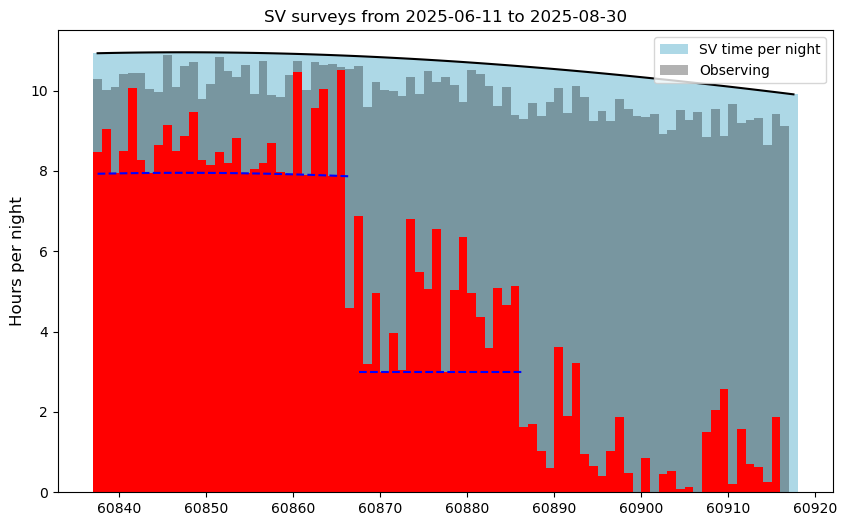

In [13]:
# Did we manage to schedule the available time? 

plt.figure(figsize=(10,6))
plt.plot(dayobsmjd, hours_in_night, 'k')
w = 1
plt.bar(dayobsmjd, downtime_per_night, width=w, color='r')
plt.bar(dayobsmjd, hours_in_night - downtime_per_night, bottom=downtime_per_night, width=w,
        color='lightblue', label="SV time per night")
plt.plot(dayobsmjd[0:step1], hours_in_night[0:step1] - 3, 'b--')
plt.plot(dayobsmjd[step1:step2], np.ones(step2-step1) * 3, 'b--')

night = np.searchsorted(dayobsmjd, observations['mjd'], side='left') - 1
obs_time = np.zeros(len(sunrises))
for i in range(len(sunrises)):
    idx = np.where((observations['mjd'] > sunsets[i]) & (observations['mjd'] < sunrises[i]))[0]
    obs_time[i-1] = (observations['exptime'][idx] + observations['slewtime'][idx]).sum() / 60 / 60

plt.bar(dayobsmjd, obs_time,  bottom=downtime_per_night, color='k', width=w, alpha=0.3, label='Observing')

plt.legend()
plt.ylabel("Hours per night", fontsize='large')
plt.title(f"SV surveys from {survey_start.iso[0:10]} to {survey_end.iso[0:10]}")

In [14]:
info = run_info_table(observatory)
converter = SchemaConverter()
run_name = 'sv_ddf_5'
converter.obs2opsim(observations, filename=run_name + ".db", info=info, delete_past=True)

visits = converter.obs2opsim(observations)
visitsdf = pd.DataFrame(visits)

out_dir = run_name
results_db = ResultsDb(out_dir=out_dir)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


{'SkyMap': <Figure size 640x480 with 2 Axes>,
 'Histogram': <Figure size 640x480 with 1 Axes>}

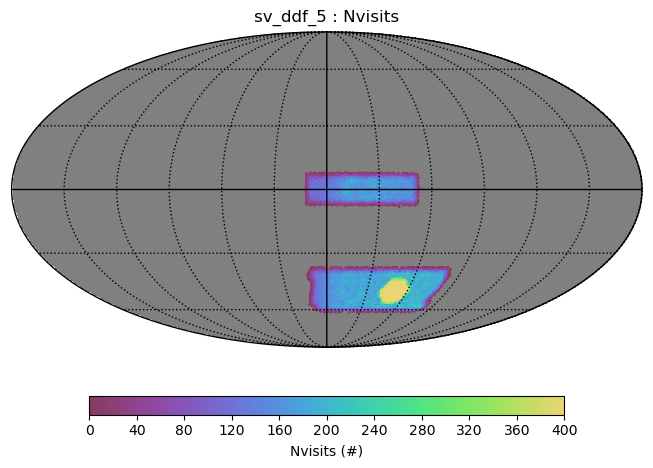

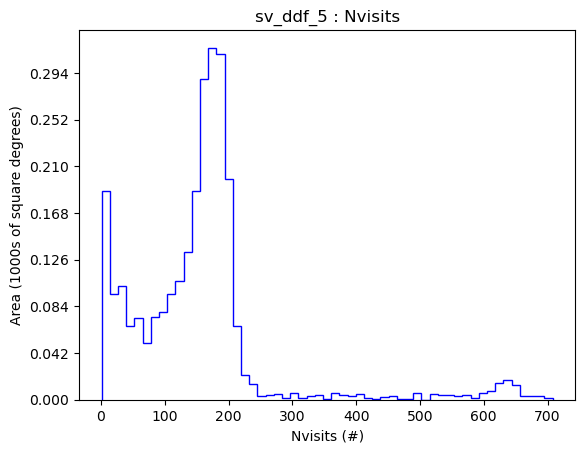

In [15]:
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
s = slicers.HealpixSlicer(64)
constraint = ''
plot_dict = {'color_min': 0, 'color_max': 400}
bundle = mb.MetricBundle(m, s, constraint, plot_dict=plot_dict, run_name=run_name)
g = mb.MetricBundleGroup({0: bundle}, None, out_dir=out_dir)
g.run_current(constraint, sim_data=visitsdf.to_records())
bundle.plot()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
g max nvisits 79.0 median 34.0
r max nvisits 146.0 median 39.0
i max nvisits 198.0 median 44.0
z max nvisits 138.0 median 39.0


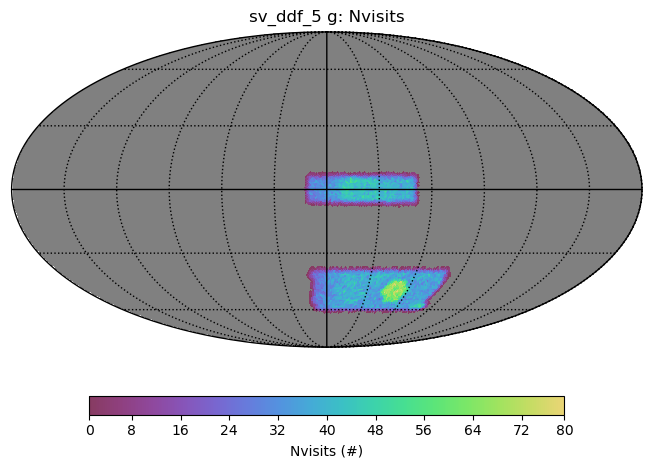

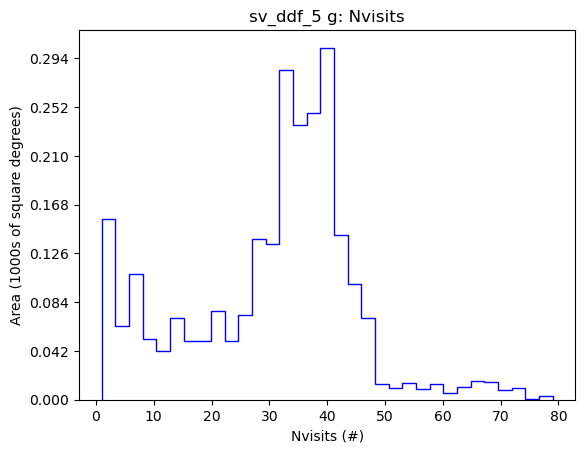

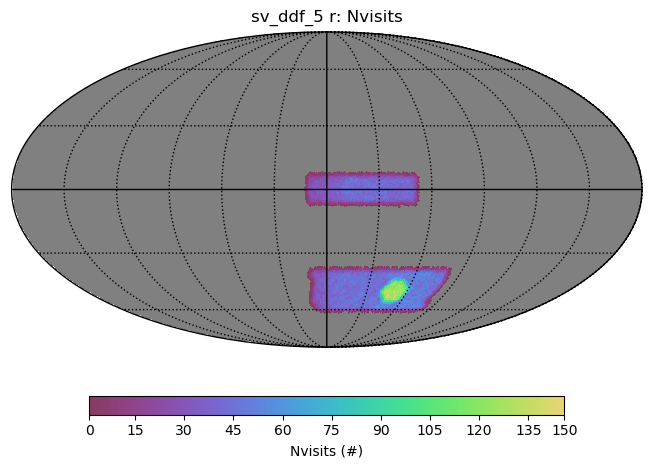

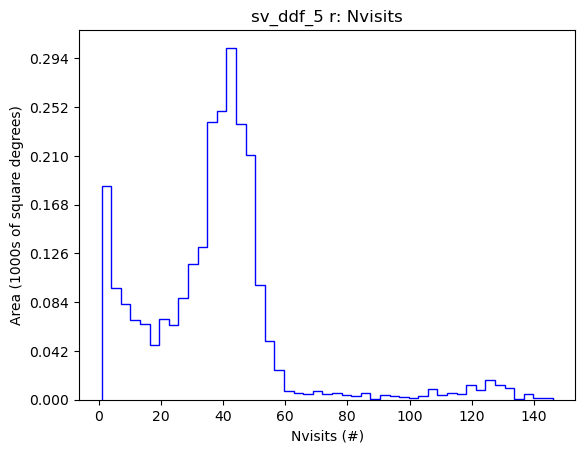

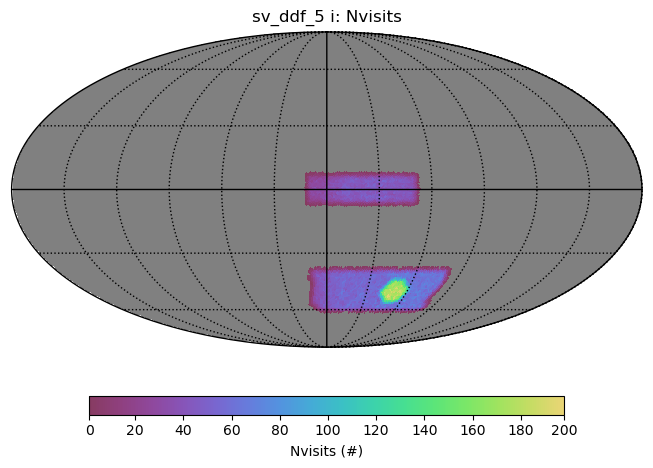

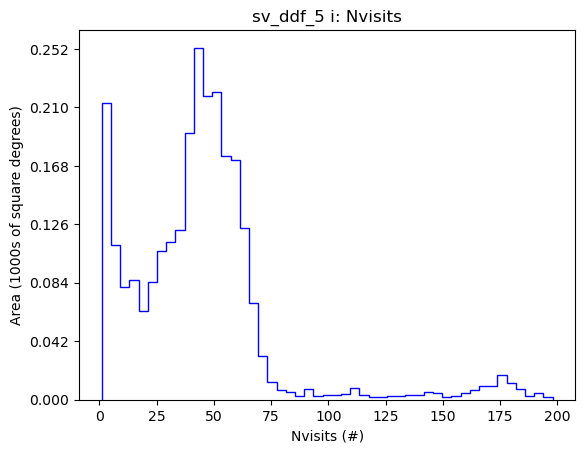

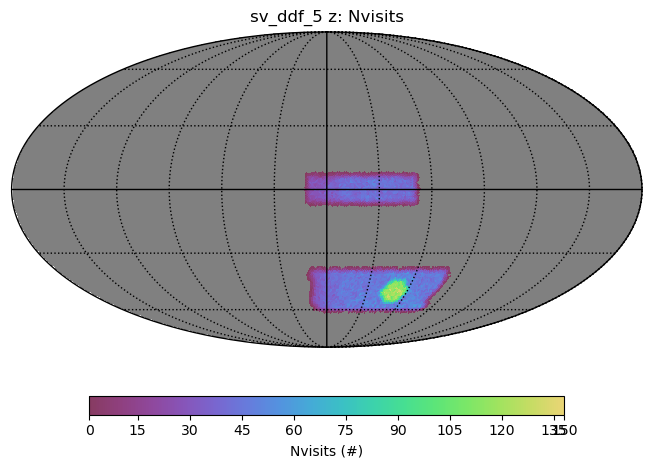

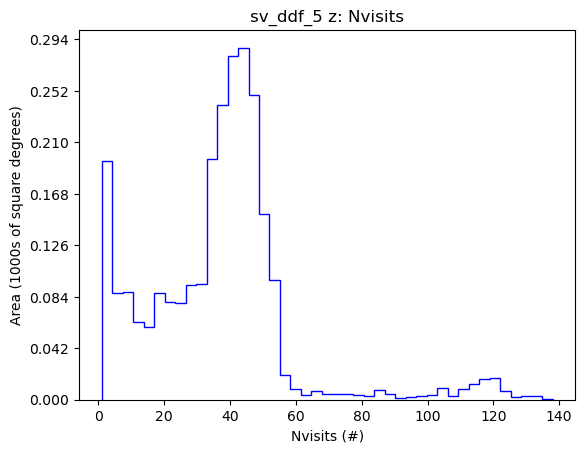

In [16]:
bundles = {}
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
s = slicers.HealpixSlicer(64)
for i, b in enumerate('griz'):
    constraint = b
    bundles[b] = mb.MetricBundle(m, s, constraint, run_name=run_name)
    g = mb.MetricBundleGroup({0: bundles[b]}, None, out_dir=out_dir)
    g.run_current(constraint, sim_data=visitsdf.query("band.str.contains(@b)").to_records())
    print(b, 'max nvisits', bundles[b].metric_values.compressed().max(), 'median', np.median(bundles[b].metric_values.compressed()))
    bundles[b].plot()

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Area with more than 800 visits 0.0
Area with more than 400 visits 115.61269962783823


{'SkyMap': <Figure size 640x480 with 2 Axes>,
 'Histogram': <Figure size 640x480 with 1 Axes>}

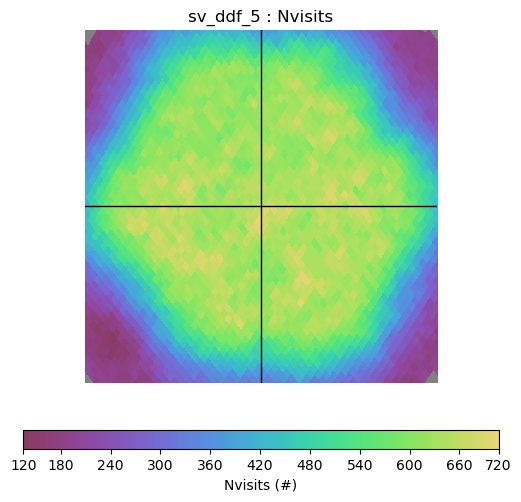

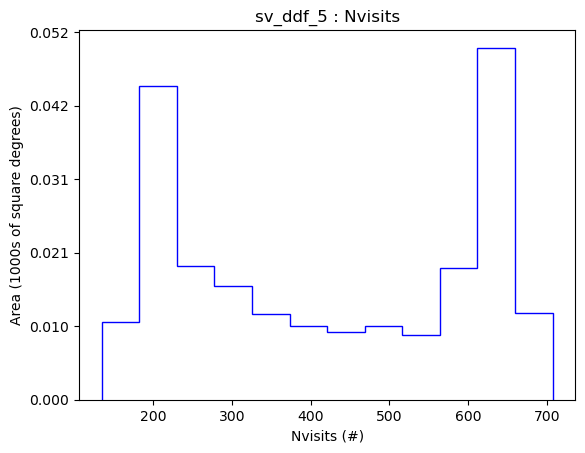

In [17]:
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
hpixnside= 256
s, plot_dict = slicers.make_circle_subset_slicer(dd_ra, dd_dec, radius=radius*1.5, nside=hpixnside, use_cache=False)
constraint = ''
bundle = mb.MetricBundle(m, s, constraint, plot_dict=plot_dict, run_name=run_name)
g = mb.MetricBundleGroup({0: bundle}, None, out_dir=out_dir)
g.run_current(constraint, sim_data=visitsdf.to_records())

print("Area with more than 800 visits", len(np.where(bundle.metric_values.compressed() > 800)[0]) * hp.nside2pixarea(hpixnside, degrees=True))
print("Area with more than 400 visits", len(np.where(bundle.metric_values.compressed() > 400)[0]) * hp.nside2pixarea(hpixnside, degrees=True))
bundle.plot()

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
No metric values calculated for band u


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:685: UserWarning: MetricBundle (sv_ddf_5_Nvisits_u_HEAL) has no "metric_values". Either the values have not been calculated or they have been deleted.
  warnings.warn(msg)


g max nvisits 81.0 median 48.0 ratio 1.0945945945945945
r max nvisits 148.0 median 85.0 ratio 0.8043478260869565
i max nvisits 202.0 median 115.0 ratio 1.0978260869565217
z max nvisits 139.0 median 80.0 ratio 0.8373493975903614
y max nvisits 182.0 median 99.0 ratio 1.0963855421686748


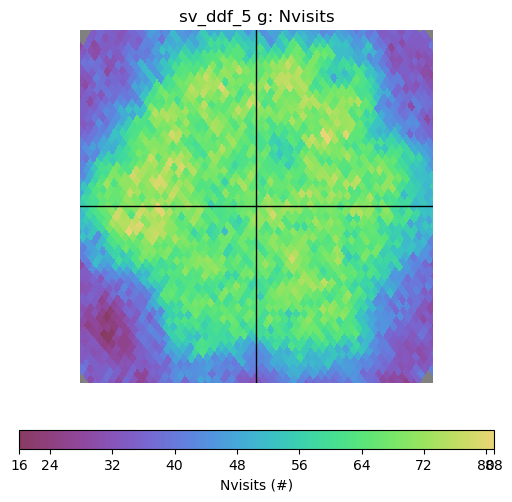

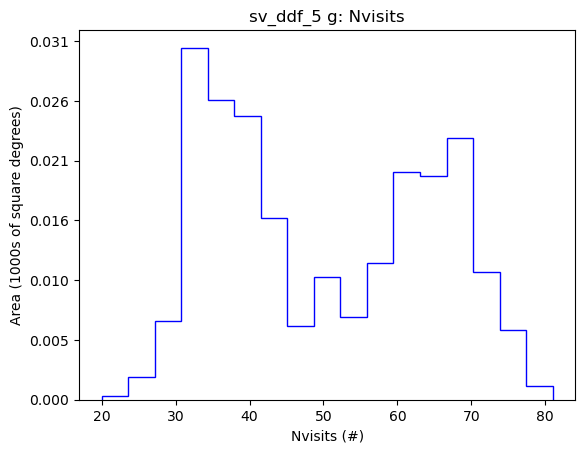

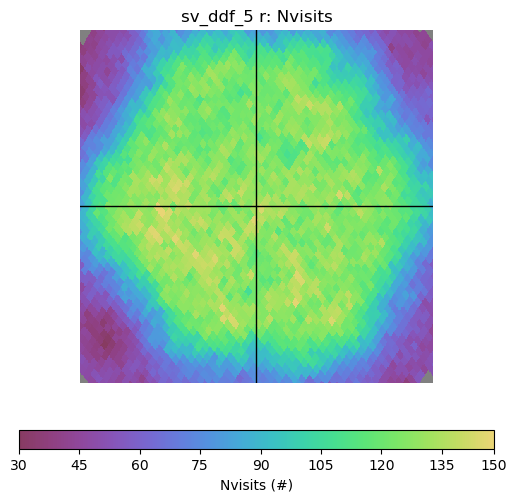

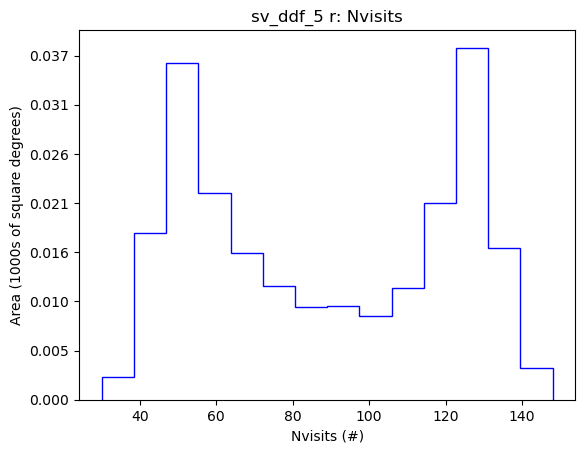

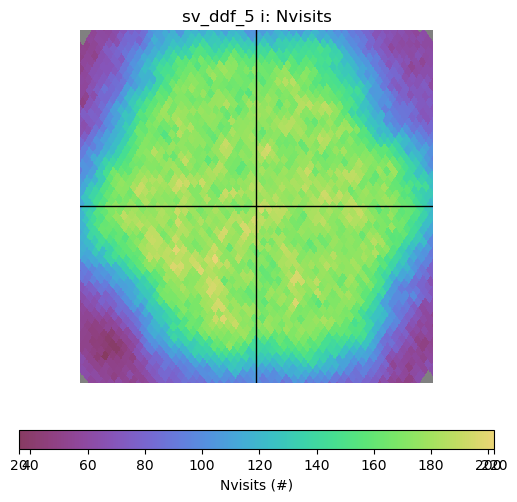

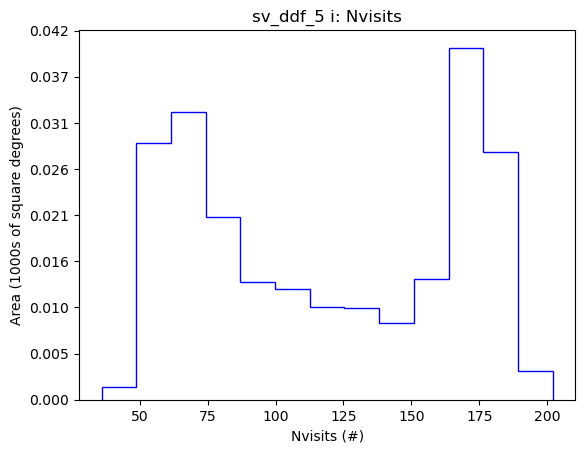

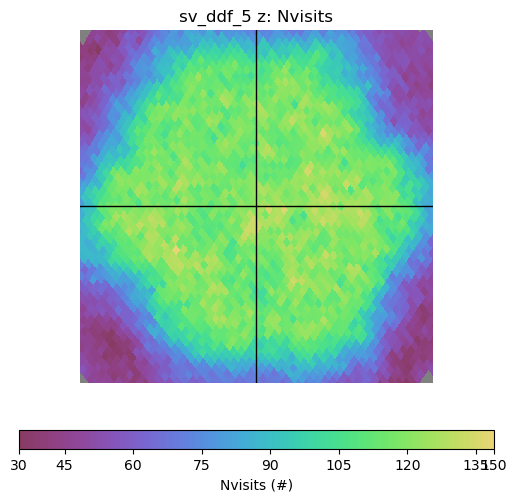

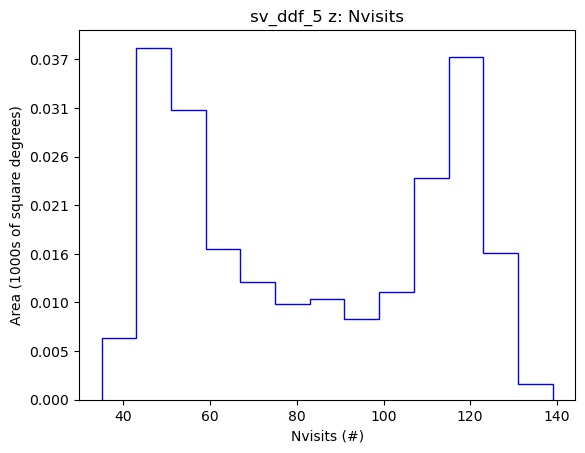

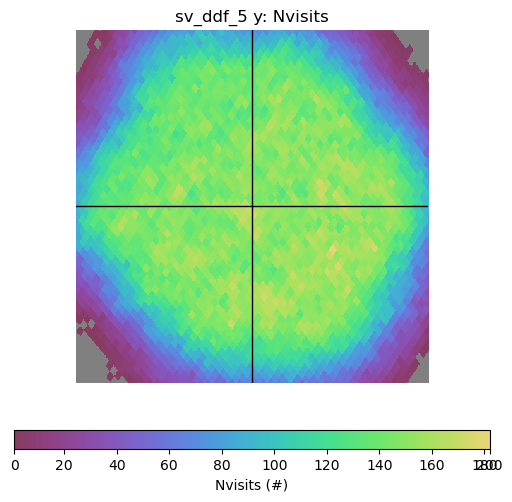

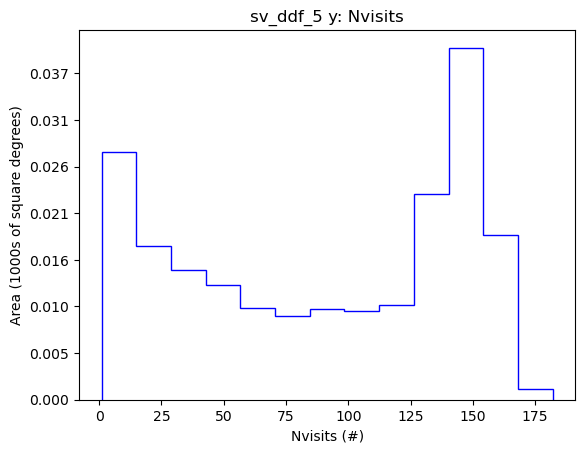

In [18]:
bundles = {}
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
hpixnside= 256
s, plot_dict = slicers.make_circle_subset_slicer(dd_ra, dd_dec, radius=radius*1.5, nside=hpixnside, use_cache=False)
for i, b in enumerate('ugrizy'):
    constraint = b
    bundles[b] = mb.MetricBundle(m, s, constraint, plot_dict=plot_dict, run_name=run_name)
    g = mb.MetricBundleGroup({0: bundles[b]}, None, out_dir=out_dir)
    sim_data = visitsdf.query("band.str.contains(@b)").to_records()
    if len(sim_data) > 0:
        g.run_current(constraint, sim_data=visitsdf.query("band.str.contains(@b)").to_records())
    if bundles[b].metric_values is not None:
        print(b, 'max nvisits', bundles[b].metric_values.compressed().max(), 'median', np.median(bundles[b].metric_values.compressed()),  'ratio', bundles[b].metric_values.compressed().max()/dd_goals[i])
    else:
        print(f"No metric values calculated for band {b}")
    bundles[b].plot()

In [19]:
print(visitsdf.scheduler_note.unique())
print(len(visitsdf), len(visitsdf.query('target_name.str.contains("DD")')))

['simple pair 33, yy, a' 'simple pair 33, yy, a, deep area'
 'simple pair 33, yy, b' 'simple pair 33, yy, b, deep area'
 'simple pair 33, iz, a' 'simple pair 33, iz, b'
 'simple pair 33, iz, a, deep area' 'simple pair 33, iz, b, deep area'
 'simple pair 33, gr, a' 'simple pair 33, gr, a, deep area'
 'simple pair 33, gr, b' 'simple pair 33, gr, b, deep area'
 'simple pair 33, ri, a' 'simple pair 33, ri, a, deep area'
 'simple pair 33, ri, b' 'simple pair 33, ri, b, deep area'
 'simple pair 33, gz, a' 'simple pair 33, gz, b'
 'simple pair 33, gz, a, deep area' 'simple pair 33, gz, b, deep area']
44164 0


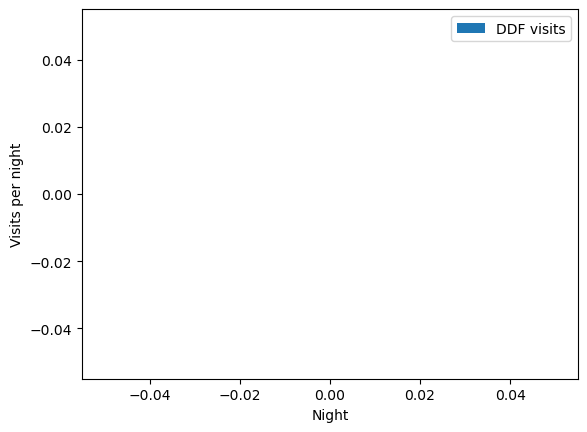

In [20]:
nights = visitsdf.query('target_name.str.contains("DD")').groupby('night').count()['observationStartMJD']
plt.bar(nights.index.values, nights.values, label='DDF visits')
plt.xlabel("Night")
plt.ylabel("Visits per night")
plt.legend()

(0.0, 1.0)

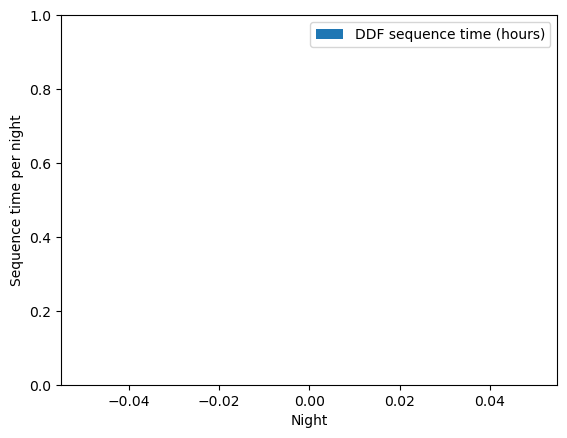

In [21]:
nights = visitsdf.query('target_name.str.contains("DD")').groupby('night').agg({'observationStartMJD': np.ptp})
plt.bar(nights.index.values, nights.observationStartMJD * 24, label='DDF sequence time (hours)')
plt.xlabel("Night")
plt.ylabel("Sequence time per night")
plt.legend()
plt.ylim(0, 1)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


{'SummaryHistogram': <Figure size 640x480 with 1 Axes>}

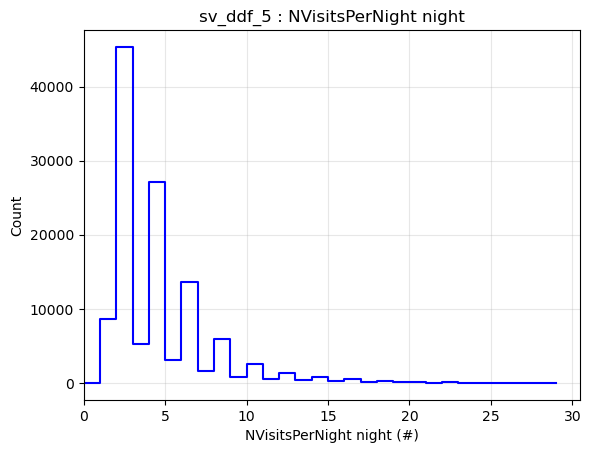

In [22]:
bins = np.arange(0, 30, 1)
m = metrics.NVisitsPerNightMetric(bins=bins)
s = slicers.HealpixSlicer(nside=64)
constraint = ''
bundle = mb.MetricBundle(m, s, constraint, run_name=run_name, 
                         plot_funcs=[plots.SummaryHistogram()], plot_dict={'bins': bins})
g = mb.MetricBundleGroup({0: bundle}, None, out_dir=out_dir)
g.run_current(constraint, sim_data=visitsdf.to_records())
bundle.plot()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


{'SummaryHistogram': <Figure size 640x480 with 1 Axes>}

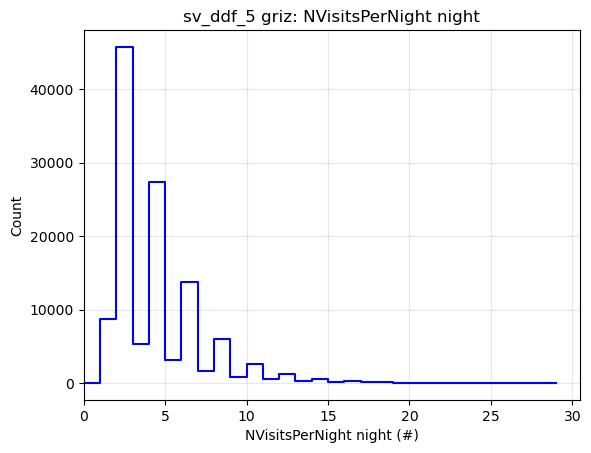

In [23]:
bins = np.arange(0, 30, 1)
m = metrics.NVisitsPerNightMetric(bins=bins)
s = slicers.HealpixSlicer(nside=64)
constraint = 'griz'
bundle = mb.MetricBundle(m, s, constraint, run_name=run_name, 
                         plot_funcs=[plots.SummaryHistogram()], plot_dict={'bins': bins})
g = mb.MetricBundleGroup({0: bundle}, None, out_dir=out_dir)
g.run_current(constraint, sim_data=visitsdf.query("band!='y' and band!='u'").to_records())
bundle.plot()

Text(0.5, 0, 'rotSkyPos (degrees) mod 90')

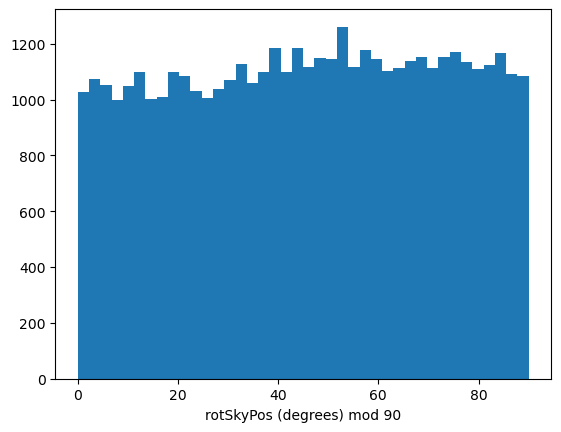

In [24]:
_temp = plt.hist(np.degrees(observations["rotSkyPos"]) % 90, bins=40)
plt.xlabel("rotSkyPos (degrees) mod 90")

Text(0.5, 0, 'rotTelPos (degrees)')

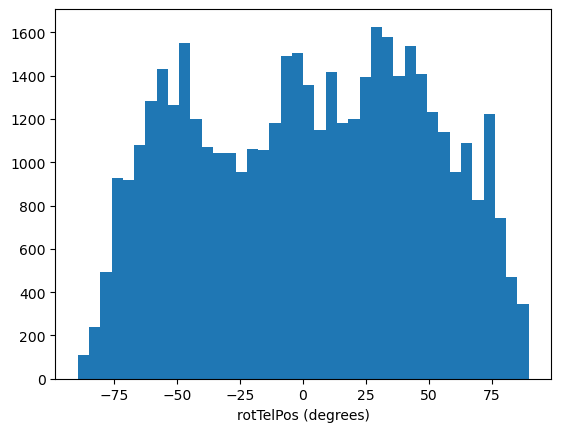

In [25]:
_temp = plt.hist(np.degrees(observations["rotTelPos"]), bins=40)
plt.xlabel("rotTelPos (degrees)")

In [26]:
ack = observations[np.where(observations["night"] == 80)]["filter"]
for name in np.unique(ack):
    print(name, np.where(ack == name)[0].size)

g 260
i 208
r 156
y 30
z 312


Text(0, 0.5, '#')

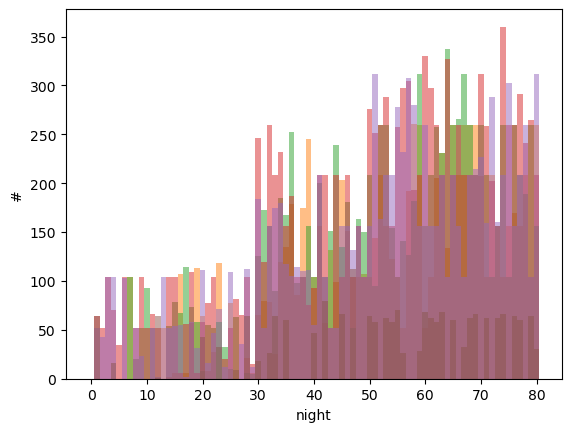

In [27]:
bins = np.arange(0, observations["night"].max() + 2, 1) - 0.5
ones = np.ones(observations.size)

for b in 'ugrizy':
    inb = np.where(observations["filter"] == b)[0]
    plt.hist(observations["night"][inb], bins=bins, label=b, alpha=0.5)
plt.xlabel("night")
plt.ylabel("#")

In [28]:
observations["night"].max()

ObservationArray(80)

In [29]:
np.unique(observations["scheduler_note"])

array(['simple pair 33, gr, a', 'simple pair 33, gr, a, deep area',
       'simple pair 33, gr, b', 'simple pair 33, gr, b, deep area',
       'simple pair 33, gz, a', 'simple pair 33, gz, a, deep area',
       'simple pair 33, gz, b', 'simple pair 33, gz, b, deep area',
       'simple pair 33, iz, a', 'simple pair 33, iz, a, deep area',
       'simple pair 33, iz, b', 'simple pair 33, iz, b, deep area',
       'simple pair 33, ri, a', 'simple pair 33, ri, a, deep area',
       'simple pair 33, ri, b', 'simple pair 33, ri, b, deep area',
       'simple pair 33, yy, a', 'simple pair 33, yy, a, deep area',
       'simple pair 33, yy, b', 'simple pair 33, yy, b, deep area'],
      dtype='<U40')

Text(0, 0.5, 'dec')

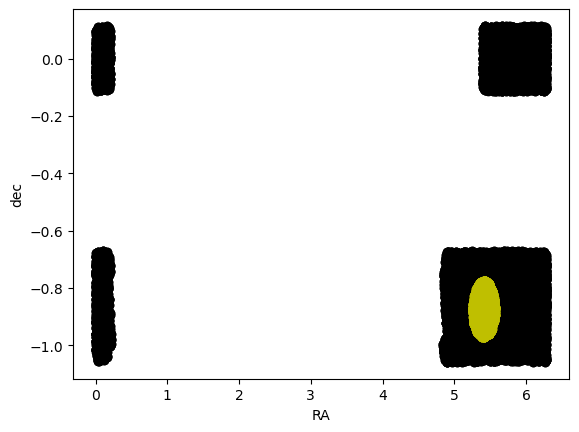

In [30]:
# check that we tagged things correctly
plt.plot(observations["RA"], observations["dec"], 'ko')
indx = [ i for i,note in enumerate(observations["scheduler_note"]) if 'deep' in note]
plt.plot(observations["RA"][indx], observations["dec"][indx], 'yo')
plt.xlabel("RA")
plt.ylabel("dec")